# Flight delay predictions

## Importing Modules

In [2]:
import pandas as pd
import numpy as np
np.random.seed(2019)

from ml_metrics import rmsle

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, make_scorer, mean_squared_error, f1_score
import xgboost as xgb

from functools import partial
from hyperopt import hp
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(12,4)
import seaborn as sns
%matplotlib inline
import math

import eli5
from eli5.sklearn import PermutationImportance
from eli5.permutation_importance import get_score_importances

## Preparing dataset

In [3]:
train = pd.read_hdf('../input/train_airline_delay.h5') # read data to data frame
test = pd.read_csv('../input/test_airline_delay.csv')

In [4]:
airports =  pd.read_csv('../input/airports.csv') # read additional airports data 
airports = airports.set_index('iata')

In [5]:
train.fillna(-1, inplace = True) 

In [6]:
df = pd.concat([train, test], axis = 0, sort = False)

## Feature Engineering

In [7]:
train['is_cancelled'] = train['is_cancelled'].factorize()[0]

In [8]:
df['lat'] = df.apply(lambda x: airports.loc[x['origin']]['lat'], axis =1) # latitiude feature
df['long'] = df.apply(lambda x: airports.loc[x['origin']]['long'], axis =1) # longitude feature 

In [9]:
df['origin_cat'] = df['origin'].factorize()[0] # factorize string data
list_airport = list(df['origin'].factorize()[1]) # each airport has the same unique number in destination and origin
df['destination_cat'] = df.apply(lambda x: list_airport.index(x['destination']), axis=1) 

In [10]:
df['traffic_origin'] = df.groupby(['origin_cat', 'year', 'month','day_of_month'])['scheduled_departure_time'].transform('count')
df['traffic_destin'] = df.groupby(['destination_cat', 'year', 'month','day_of_month'])['scheduled_departure_time'].transform('count')

In [11]:
mean_delay_per_carrier = train.groupby(['carrier_id'])['target_delay'].mean().to_dict()
df['mean_delay_per_carrier'] = df['carrier_id'].map(mean_delay_per_carrier)

In [12]:
# normalized sum of all delays per carrier
carrier_delay = train.groupby('carrier_id')['target_delay'].sum().to_dict()
df['carrier_delay'] = df['carrier_id'].map(carrier_delay)
df['carrier_delay'] = df['carrier_delay']/(train.groupby('carrier_id')['target_delay'].sum()).max()

In [13]:
train = df[pd.isna(df['is_cancelled']) == False]
mean_delay_per_airport = list(train.groupby(['origin_cat'])['target_delay'].mean())
mean_delay_per_airport.append(0) 
df['mean_delay_per_airport'] = df.apply(lambda x: mean_delay_per_airport[x['origin_cat']], axis=1 )

In [14]:
# frequency of delays per carrier
train['is_delay'] = train.apply(lambda x : int(x['target_delay'] >0 ), axis=1)
delay_frequency = np.array(list(train.groupby(['carrier_id'])['is_delay'].agg(sum)))
carrier_frequency =np.array(list(train.groupby(['carrier_id'])['is_delay'].count()))
delay_frequency = delay_frequency/carrier_frequency
df['delay_frequency'] = df.apply(lambda x: delay_frequency[x['carrier_id']], axis=1 )

/home/jupyter/anaconda3_new/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [15]:
# time in decimal form
df['time_of_departure'] = df.apply(lambda x: ( (x['scheduled_departure_time'])//100 + ((x['scheduled_departure_time']/100)%1)/0.6 ) , axis =1)

In [16]:
# mean delay per month
month_delay = train.groupby('month')['target_delay'].sum().to_dict()
df['month_delay'] = df['month'].map(month_delay)/(train.groupby('month')['target_delay'].sum().max())

In [17]:
# mean delay per year
year_delay = train.groupby('year')['target_delay'].sum().to_dict()
df['year_delay'] = df['year'].map(year_delay)/(train.groupby('year')['target_delay'].sum().max())

In [18]:
df['sum_delay'] = df.apply(lambda x: x['mean_delay_per_airport'] + x['mean_delay_per_carrier'], axis = 1)

In [19]:
# split data frame in train and test
test = df[pd.isna(df['is_cancelled'])==True]
train = df[pd.isna(df['is_cancelled']) == False]
test['id'] = test['id'].apply(np.int64)

/home/jupyter/anaconda3_new/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


## is_cancell predictions

In [20]:
# features used in is_cancell prediction model:

feats_side = [
             'year',
             'month',
             'day_of_month',
             'day_of_week',
             'time_of_departure',
             'distance',
             'delay_frequency',
             'flight_number',
             'tail_number',
             'scheduled_elapsed_time',
             'origin_cat',
             'destination_cat',
             'lat',
             'long',
             'traffic_origin', 
             'traffic_destin',
             'mean_delay_per_carrier',
             'mean_delay_per_airport'
             ]

In [ ]:
# hyperopt for is_cancell predictions, default n_estimators = 40

y_side = train['is_cancelled'].values
X_side = train[feats_side].values
X_train, X_test, y_train, y_test = train_test_split( X_side, y_side, test_size = 0.3, random_state=2019 )

def objective_cancelled(space):
    
    xgb_params = {
        'max_depth': int(space['max_depth']),
        'colsample_bytree': space['colsample_bytree'],
        'learning_rate': space['learning_rate'],
        'subsample': space['subsample'],
        'min_child_weight': int(space['min_child_weight']),
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        'n_estimators': 40
    }
    
    model = xgb.XGBClassifier(**xgb_params, n_jobs=8)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    score = precision_score(y_test, y_pred)
    
    print("SCORE: {0}".format(score))
    
    return{'loss':  1-score, 'status': STATUS_OK }
    
space = {
    'max_depth': hp.quniform ('x_max_depth', 5, 15, 1),
    'colsample_bytree': hp.uniform ('x_colsample_bytree', 0.8, 1.),
    'learning_rate': hp.uniform ('x_learning_rate', 0.05, 0.6),
    'subsample': hp.uniform ('x_subsample', 0.7, 1.),
    'min_child_weight': hp.quniform ('x_min_child_weight', 1, 10, 1),
    'reg_alpha': hp.loguniform ('x_reg_alpha', 0., 1.),
    'reg_lambda': hp.uniform ('x_reg_lambda', 0.7, 1.)
}

trials = Trials()
best_params = fmin(fn=objective_cancelled,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=30,
            trials=trials)

print("The best params: ", best_params)

In [21]:
# parameters obtained from hyperopt:

params_side = {
    'colsample_bytree': 0.8798095831444906, 
    'learning_rate': 0.1818529507370009, 
    'max_depth': 8, 
    'min_child_weight': 4.0, 
    'reg_alpha': 1.3478496575484795, 
    'reg_lambda': 0.7473794685595935, 
    'subsample': 0.871807966795143,
    'n_estimators' : 40,
    'n_jobs' : 8,
    'random_seed' : 2019
}  

side_model = xgb.XGBClassifier(**params_side)

y_train = train['is_cancelled'].values
X_train = train[feats_side].values
X_test = test[feats_side].values

side_model.fit(X_train, y_train)

y_pred = side_model.predict(X_train)
train['is_cancelled_pred'] = y_pred

y_pred = side_model.predict(X_test)
test['is_cancelled_pred'] = y_pred


/home/jupyter/anaconda3_new/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/jupyter/anaconda3_new/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Delay prediction - Main Model 

In [22]:
#definition of root mean square error metric 

def rmse(y, y0):
     return np.sqrt(np.mean(np.square(y - y0)))

In [23]:
# features used for delay predictions:

feats_main = [ 
             'is_cancelled_pred',
             'delay_frequency',
             'year',
             'month',
             'month_delay',
             'mean_delay_per_carrier',
             'day_of_month',
             'traffic_destin',
             'traffic_origin', 
             'day_of_week',
             'mean_delay_per_airport',
             'time_of_departure',
             'year_delay',
             'sum_delay',
             'lat',
             'long',
             'carrier_delay',
             'origin_cat',
             'destination_cat',  
              ]

In [ ]:
# hyperopt parameters optimalization for delay prediction model, default n_estimators = 100 :

X = train[feats].values
y = train['target_delay'].values
y_log = np.log1p(y)

X_train, X_test, y_train, y_test = train_test_split( X, y_log, test_size = 0.3, random_state=2019 )

def objective(space):
    
    xgb_params = {
        'max_depth': int(space['max_depth']),
        'colsample_bytree': space['colsample_bytree'],
        'learning_rate': space['learning_rate'],
        'subsample': space['subsample'],
        'min_child_weight': int(space['min_child_weight']),
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        'n_estimators': 100 
    }
    
    model = xgb.XGBRegressor(**xgb_params, n_jobs=8)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    score = rmse(y_test, y_pred)
    
    print("SCORE: {0}".format(score))
    
    return{'loss':score, 'status': STATUS_OK }
    
space = {
    'max_depth': hp.quniform ('x_max_depth', 5, 10, 1),
    'colsample_bytree': hp.uniform ('x_colsample_bytree', 0.8, 1.),
    'learning_rate': hp.uniform ('x_learning_rate', 0.01, 0.4),
    'subsample': hp.uniform ('x_subsample', 0.7, 1.),
    'min_child_weight': hp.quniform ('x_min_child_weight', 1, 10, 1),
    'reg_alpha': hp.loguniform ('x_reg_alpha', 0., 1.),
    'reg_lambda': hp.uniform ('x_reg_lambda', 0.7, 1.)
}

trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=40,
            trials=trials)

print("The best params: ", best_params)

In [24]:
#parameters calculated by hyperopt:

params_main =  {
    'max_depth' : 10,
    'colsample_bytree': 0.9840056172835638, 
    'learning_rate': 0.2458785842030256, 
    'min_child_weight': 7.0, 
    'reg_alpha': 2.1994825940843126, 
    'reg_lambda': 0.909929806541402, 
    'subsample': 0.8341216013590944,
    'n_estimators' : 100,
    'n_jobs' : 8,
    'random_state' : 2019
}


X = train[feats_main].values
y = train['target_delay'].values
y_log = np.log1p(y)
X_train, X_test, y_train, y_test = train_test_split( X, y_log, test_size = 0.3, random_state = 2019 )

model = xgb.XGBRegressor(**params_main)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
rmse(y_test, y_pred)


1.5349092692311337

## Feature importance and learning curve

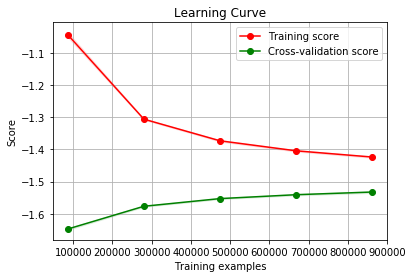

In [33]:
X = train[feats_main].values
y = train['target_delay'].values
y_log = np.log1p(y)

import scikitplot as skplt
rmse_score = make_scorer(rmse, greater_is_better=False)

skplt.estimators.plot_learning_curve(model, X, y_log, cv=5, scoring=rmse_score)

In [25]:
def draw_feature_importances(model, features):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 5))
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), model.feature_importances_[indices],
           color="b", align="center")
    plt.xticks(range(X.shape[1]), [ features[x] for x in indices])
    plt.xticks(rotation=90)
    plt.xlim([-1, X.shape[1]])
    plt.yscale('log')
    plt.show()

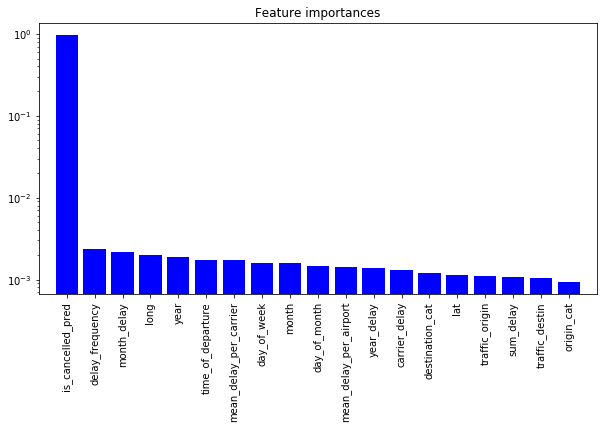

In [26]:
model.fit(X_train, y_train)

draw_feature_importances(model, feats_main)   

In [28]:
eli5.show_weights(model, feature_names=feats_main, top=50)

Weight,Feature
0.9729,is_cancelled_pred
0.0024,delay_frequency
0.0021,month_delay
0.0020,long
0.0019,year
0.0018,time_of_departure
0.0017,mean_delay_per_carrier
0.0016,day_of_week
0.0016,month
0.0015,day_of_month


In [29]:
eli5.show_weights(model.get_booster(), feature_names=feats_main, top=50, importance_type='gain')

Weight,Feature
0.9729,is_cancelled_pred
0.0024,delay_frequency
0.0021,month_delay
0.0020,long
0.0019,year
0.0018,time_of_departure
0.0017,mean_delay_per_carrier
0.0016,day_of_week
0.0016,month
0.0015,day_of_month


In [30]:
eli5.explain_weights_xgboost(model.get_booster(), feature_names=feats_main, top=50, importance_type='cover' )

Weight,Feature
0.6217,is_cancelled_pred
0.0342,destination_cat
0.0297,sum_delay
0.0269,delay_frequency
0.0237,origin_cat
0.0235,long
0.0230,traffic_destin
0.0221,mean_delay_per_carrier
0.0211,mean_delay_per_airport
0.0208,traffic_origin


In [31]:
X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_train, y_train, shuffle=True, random_state=0)

perm = PermutationImportance(model).fit(X_sub_test, y_sub_test)
eli5.show_weights(perm, feature_names=feats_main, top=50)

Weight,Feature
0.3449 ± 0.0034,is_cancelled_pred
0.1326 ± 0.0010,time_of_departure
0.1062 ± 0.0013,day_of_month
0.0836 ± 0.0010,month_delay
0.0773 ± 0.0016,traffic_destin
0.0687 ± 0.0008,month
0.0638 ± 0.0009,traffic_origin
0.0613 ± 0.0005,destination_cat
0.0605 ± 0.0003,day_of_week
0.0545 ± 0.0011,long


## Calculated predictions for test dataset

In [32]:
X = test[feats_main].values
y_pred_log = model.predict(X)
y_pred = np.expm1(y_pred_log)

test['target_delay'] = y_pred
test[ ['id', 'target_delay'] ].to_csv('../output/model_xgb.csv', index=False) 

/home/jupyter/anaconda3_new/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
